In [2]:
import pathlib
import time

import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


**Stage 1: Baseline Model**

Data Preparation:
- Loaded and normalized Fashion MNIST.
- Split into train, validation, and test sets.

Model Design:
- Built a CNN with 2 convolutional layers (3x3 filters).
- Added max pooling and fully connected layers.

Training Setup:
- Batch size: 64, Learning rate: 0.001. Epochs: 5.
- Used Adam optimizer and cross-entropy loss.

Training and Validation:
- Tracked loss and accuracy on validation/test sets.

Baseline Results:
- Accuracy: 90.41%, Time: 63.83 sec (5 epochs).

In [4]:
training_data_filepath = pathlib.Path('/content/drive/MyDrive/CODING FILES/fashion-mnist_train.csv')
training_data = pl.read_csv(training_data_filepath)

test_data_filepath = pathlib.Path('/content/drive/MyDrive/CODING FILES/fashion-mnist_test.csv')
test_data = pl.read_csv(test_data_filepath)



In [5]:
train_features = training_data.drop(
    'label'
  ).with_columns(
      pl.all()/255.0
  )

train_targets = training_data.select(
    'label'
).cast(
    pl.Int32
).to_dummies()

X_train = train_features.to_numpy()
y_train = train_targets.to_numpy()

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

test_features = test_data.drop(
    'label'
  ).with_columns(
      pl.all()/255.0
  )

test_targets = test_data.select(
    'label'
).cast(
    pl.Int32
).to_dummies()

X_test = test_features.to_numpy()
y_test = test_targets.to_numpy()


In [6]:
class FashionMNISTDataset(Dataset):
  def __init__(self, features, targets):
    self.features = features
    self.targets = targets

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    features = self.features[idx].reshape(28,28).astype('float32')
    targets = self.targets[idx].astype('float32')
    return torch.tensor(features), torch.tensor(targets)

In [7]:
batch_size = 64
num_epochs = 10
learning_rate = 0.001

train_dataset = FashionMNISTDataset(X_train, y_train)
val_dataset = FashionMNISTDataset(X_val, y_val)
test_dataset = FashionMNISTDataset(X_test, y_test)

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1_input_size = self._get_fc1_input_size(filter_size1, filter_size2, num_features2)
        self.fc1 = nn.Linear(self.fc1_input_size, 128)
        self.fc_relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
          x = self.pool1(self.relu1(self.conv1(x)))
          x = self.pool2(self.relu2(self.conv2(x)))
          x = x.view(-1, 64 * 5 * 5)
          x = self.fc_relu(self.fc1(x))
          x = self.fc2(x)
          return x

In [9]:
num_epochs = 5
batch_size = 64
learning_rate = 0.001


In [10]:
torch.manual_seed(0)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

start_time = time.time()

training_history = []
for epoch in range(num_epochs):
    model.train()
    running_training_loss = 0.0
    for images, labels in train_loader:
        images = images.unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_training_loss += loss.item()

    training_loss = running_training_loss / len(train_loader)
    training_history.append({
        'epoch': epoch+1,
        'phase': 'Training',
        'loss': training_loss
    })

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    validation_loss = running_val_loss / len(val_loader)
    training_history.append({
        'epoch': epoch+1,
        'phase': 'Validation',
        'loss': validation_loss
    })

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {training_loss:.4f}, Validation Loss: {validation_loss:.4f}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f' - Training for {num_epochs} epochs took {elapsed_time:.2f} seconds.')

Epoch [1/5], Training Loss: 0.5583, Validation Loss: 0.4009
Epoch [2/5], Training Loss: 0.3595, Validation Loss: 0.3397
Epoch [3/5], Training Loss: 0.3028, Validation Loss: 0.3156
Epoch [4/5], Training Loss: 0.2676, Validation Loss: 0.2700
Epoch [5/5], Training Loss: 0.2428, Validation Loss: 0.2647
 - Training for 5 epochs took 63.83 seconds.


In [12]:
model.to(device)

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.unsqueeze(1).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.argmax(axis=1)).sum().item()
print(f"Accuracy of the model on the test images: {100 * correct / total:.2f}%")

Accuracy of the model on the test images: 90.41%


**Stage 2: Experimentation**

Model Design:
- Built ConfigurableCNN to test:
  - Filter sizes: 3x3, 5x5
  - Features: (16, 32), (32, 64), (64, 128)
  - Batch sizes: 32, 64, 128

Experimentation:
- Ran nested loops over all configurations.
- Trained each for 5 epochs and recorded accuracy and time.

Performance Measurement:
- Stored results in a DataFrame for comparison.

In [21]:
class ConfigurableCNN(nn.Module):
    def __init__(self, filter_size1, filter_size2, num_features1, num_features2):
        super(ConfigurableCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, num_features1, kernel_size=filter_size1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(num_features1, num_features2, kernel_size=filter_size2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1_input_size = self._get_fc1_input_size(filter_size1, filter_size2, num_features2)
        self.fc1 = nn.Linear(self.fc1_input_size, 128)
        self.fc_relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def _get_fc1_input_size(self, filter_size1, filter_size2, num_features2):
        input_size = 28
        x = torch.randn(1, 1, input_size, input_size)
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))

        return x.view(1, -1).shape[1]

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, self.fc1_input_size)
        x = self.fc_relu(self.fc1(x))
        return self.fc2(x)

In [20]:
filter_sizes = [(3, 3),(5, 5)]
num_features_options = [(16, 32), (32, 64), (64, 128)]
num_epochs = 5
learning_rate = 0.001
batch_sizes = [32, 64, 128]

results = []

for filter_size1, filter_size2 in filter_sizes:
    for num_features1, num_features2 in num_features_options:
        for batch_size in batch_sizes:
            print(f"Running experiment with: Filter Size: ({filter_size1}, {filter_size2}), "
                  f"Features: ({num_features1}, {num_features2}), Batch Size: {batch_size}")

            model = ConfigurableCNN(filter_size1, filter_size2, num_features1, num_features2).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            start_time = time.time()
            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0

                for images, labels in train_loader:
                    images = images.unsqueeze(1).to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()

            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.unsqueeze(1).to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels.argmax(axis=1)).sum().item()

            accuracy = 100 * correct / total
            elapsed_time = time.time() - start_time

            print(f"Accuracy: {accuracy:.2f}%, Time: {elapsed_time:.2f} seconds")

            results.append({
                'filter_size1': filter_size1,
                'filter_size2': filter_size2,
                'num_features1': num_features1,
                'num_features2': num_features2,
                'batch_size': batch_size,
                'accuracy': accuracy,
                'time': elapsed_time
            })

results_df = pd.DataFrame(results)
print(results_df)


Running experiment with: Filter Size: (3, 3), Features: (16, 32), Batch Size: 32
Accuracy: 90.16%, Time: 23.93 seconds
Running experiment with: Filter Size: (3, 3), Features: (16, 32), Batch Size: 64
Accuracy: 89.03%, Time: 15.26 seconds
Running experiment with: Filter Size: (3, 3), Features: (16, 32), Batch Size: 128
Accuracy: 87.79%, Time: 10.45 seconds
Running experiment with: Filter Size: (3, 3), Features: (32, 64), Batch Size: 32
Accuracy: 90.86%, Time: 23.85 seconds
Running experiment with: Filter Size: (3, 3), Features: (32, 64), Batch Size: 64
Accuracy: 89.97%, Time: 15.05 seconds
Running experiment with: Filter Size: (3, 3), Features: (32, 64), Batch Size: 128
Accuracy: 88.92%, Time: 10.52 seconds
Running experiment with: Filter Size: (3, 3), Features: (64, 128), Batch Size: 32
Accuracy: 91.05%, Time: 24.43 seconds
Running experiment with: Filter Size: (3, 3), Features: (64, 128), Batch Size: 64
Accuracy: 89.28%, Time: 15.14 seconds
Running experiment with: Filter Size: (3, 3)

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

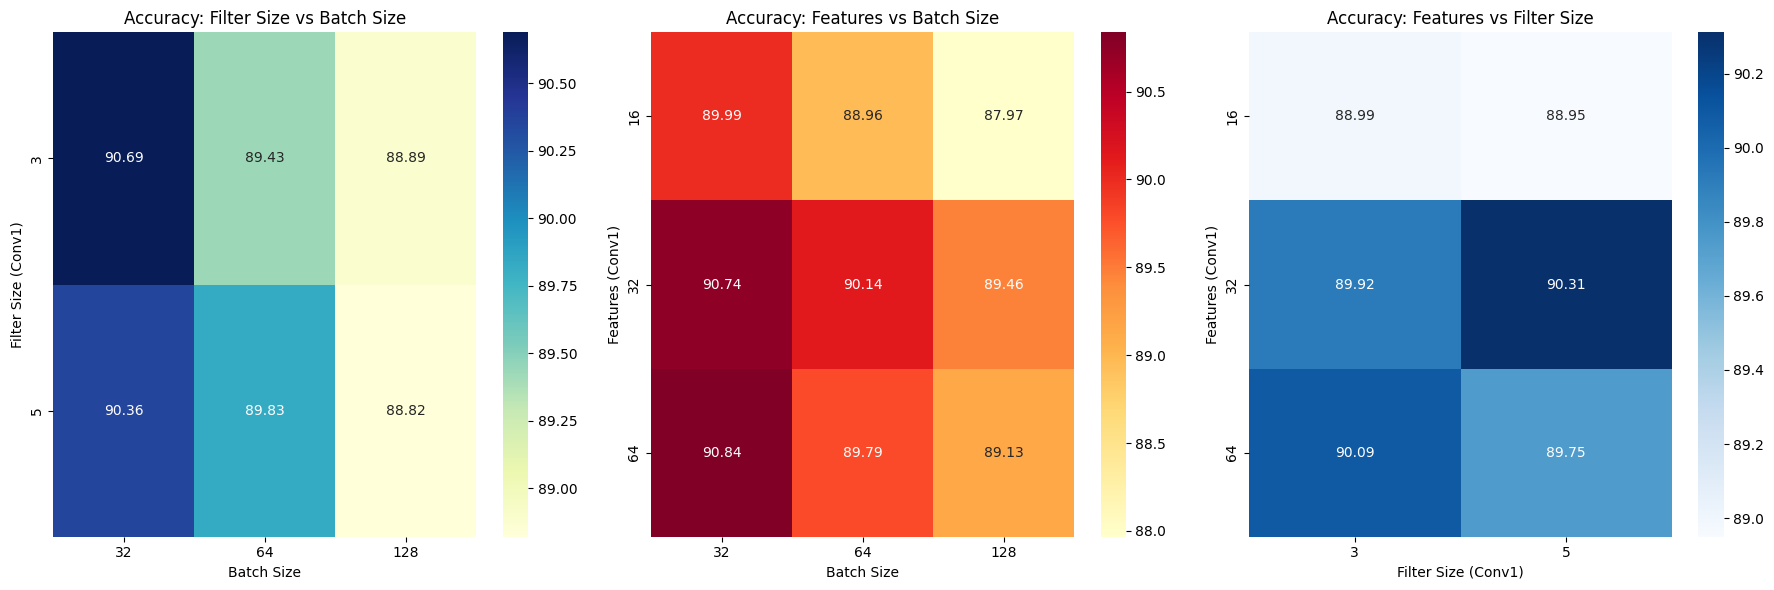

In [33]:
fig, axes = plt.subplot_mosaic(
    [
        ['Filter_Size',
         'Batch_Size',
         'Features']
    ],
    figsize=(18, 6)
)

batch_filter_data = results_df.pivot_table(
    values='accuracy',
    index='filter_size1',
    columns='batch_size'
)

sns.heatmap(
    batch_filter_data,
    annot=True,
    cmap='YlGnBu',
    fmt=".2f",
    ax=axes['Filter_Size']
)
axes['Filter_Size'].set_title('Accuracy: Filter Size vs Batch Size')
axes['Filter_Size'].set_xlabel('Batch Size')
axes['Filter_Size'].set_ylabel('Filter Size (Conv1)')

features_batch_data = results_df.pivot_table(
    values='accuracy',
    index='num_features1',
    columns='batch_size'
)

sns.heatmap(
    features_batch_data,
    annot=True,
    cmap='YlOrRd',
    fmt=".2f",
    ax=axes['Batch_Size']
)
axes['Batch_Size'].set_title('Accuracy: Features vs Batch Size')
axes['Batch_Size'].set_xlabel('Batch Size')
axes['Batch_Size'].set_ylabel('Features (Conv1)')

features_filter_data = results_df.pivot_table(
    values='accuracy',
    index='num_features1',
    columns='filter_size1'
)

sns.heatmap(
    features_filter_data,
    annot=True,
    cmap='Blues',
    fmt=".2f",
    ax=axes['Features']
)
axes['Features'].set_title('Accuracy: Features vs Filter Size')
axes['Features'].set_xlabel('Filter Size (Conv1)')
axes['Features'].set_ylabel('Features (Conv1)')

plt.tight_layout()
plt.show()


**Stage 3: Analysis**

***Baseline Results:***
*   Accuracy on the test set: 90.41%
*   Training Time: 63.83 seconds for 5 Epochs

***Experimentation Process:***

Filter Sizes:

- 3x3 (same as baseline)
- 5x5 (increased size)

Number of Features (Output Channels):
- Halved: (16, 32)
- Same as baseline: (32, 64)
- Increased: (64, 128)

Batch Sizes:
- 32
- 64
- 128

Filter Size:
- 3x3 filters offered better performance with shorter training times.
- 5x5 filters showed minimal accuracy improvement but increased computational time due to higher complexity.

Features:
- Reducing features to (16, 32) lowered accuracy (87-89%).
- Increasing features to (64, 128) slightly improved accuracy (up to 91.05%) but increased training time significantly.
- The baseline (32, 64) strikes the best balance.

Batch Size:
- Batch size 32 gave marginally higher accuracy but at the cost of longer training time.
- Batch size 128 reduced time but resulted in lower accuracy.
- Batch size 64 provided the optimal trade-off between accuracy and speed.







